In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
!pip install mediapipe==0.8.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mediapipe==0.8.5 (from versions: 0.8.9.1, 0.8.10, 0.8.10.1, 0.8.11, 0.9.0, 0.9.0.1, 0.9.1.0, 0.9.2.1, 0.9.3.0, 0.10.0)
ERROR: No matching distribution found for mediapipe==0.8.5


In [ ]:
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# Read the csv file to get data
csv_folder = '/content/drive/MyDrive/PBL5/_Bottom-up-Framework/New_Data/CSV'


In [ ]:
no_of_timesteps = 30
X = []
y = []

In [ ]:
for file in os.listdir(csv_folder):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(csv_folder, file))

        # create variable for each csv file
        label = file[:-4] # label for each file is the file name without ".csv" extension

        # create binary label for "fall" and "not fall"
        if "fall" in label:
            y_label = 1 # 1 for "fall"
        else:
            y_label = 0 # 0 for "not fall"

        dataset = df.iloc[:, 1:].values
        n_sample = len(dataset)

        for i in range(no_of_timesteps, n_sample):
            X.append(dataset[i-no_of_timesteps:i, :]) # 10 timesteps added to X
            y.append(y_label) # binary label added to y


        # for i in range(0, n_sample - 30 + 1):
        #     X.append(dataset[i:i + 30, :]) # 10 timesteps added to X
        #     y.append(y_label) # binary label added to y


In [ ]:
X, y = np.array(X), np.array(y)

with open('/content/drive/MyDrive/PBL5/_Bottom-up-Framework/New_Data/CSV/features_30_frames.npy', "wb") as f:
        np.save(f, X)
        f.close()

with open('/content/drive/MyDrive/PBL5/_Bottom-up-Framework/New_Data/CSV/labels_30_frames.npy', "wb") as f:
        np.save(f, y)
        f.close()

print(X.shape, y.shape) # (num_samples, 10, num_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

(17353, 30, 132) (17353,)


**Define the model**

Mô hình được xây dựng với 4 lớp LSTM (units=50) xếp chồng lên nhau, và lớp đầu tiên có tham số "return_sequences=True" để truyền tải thông tin đến lớp tiếp theo. Mỗi lớp LSTM được áp dụng một lớp Dropout với tỷ lệ 0.2 để tránh overfitting.

Sau 4 lớp LSTM, một lớp Dense với 1 đơn vị và hàm kích hoạt sigmoid được thêm vào để tạo ra đầu ra dự đoán cho bài toán phân loại nhị phân.

Mô hình được biên dịch với optimizer Adam (learning_rate=0.001) và loss function là binary crossentropy. Đồng thời, mô hình cũng được đánh giá với metric là accuracy.

In [ ]:
model = Sequential() # Stacked LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model

history = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_test, y_test))

model.save("/content/drive/MyDrive/PBL/PBL5/_Bottom-up-Framework/New_Data/model_v1.h5")
# batch size: the specifies number of samples that will be processed in each update of the model's weight during training.
# that mean 32 samples will be processed in each update of the model's weight.


Epoch 1/16
434/434 [==============================] - 20s 16ms/step - loss: 0.3165 - accuracy: 0.8678 - val_loss: 0.1588 - val_accuracy: 0.9432
Epoch 2/16
434/434 [==============================] - 6s 15ms/step - loss: 0.1412 - accuracy: 0.9476 - val_loss: 0.0939 - val_accuracy: 0.9683
Epoch 3/16
434/434 [==============================] - 6s 13ms/step - loss: 0.1073 - accuracy: 0.9616 - val_loss: 0.0677 - val_accuracy: 0.9772
Epoch 4/16
434/434 [==============================] - 6s 15ms/step - loss: 0.0769 - accuracy: 0.9731 - val_loss: 0.0516 - val_accuracy: 0.9787
Epoch 5/16
434/434 [==============================] - 5s 12ms/step - loss: 0.0585 - accuracy: 0.9790 - val_loss: 0.0396 - val_accuracy: 0.9839
Epoch 6/16
434/434 [==============================] - 6s 14ms/step - loss: 0.0542 - accuracy: 0.9806 - val_loss: 0.0381 - val_accuracy: 0.9842
Epoch 7/16
434/434 [==============================] - 6s 13ms/step - loss: 0.0415 - accuracy: 0.9847 - val_loss: 0.0665 - val_accuracy: 0.979

In [ ]:
# Evaluate the model on test data
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

109/109 [==============================] - 1s 7ms/step - loss: 0.0098 - accuracy: 0.9971
Test loss: 0.009813986718654633
Test accuracy: 0.9971190094947815


In [ ]:
# from keras.layers import Bidirectional

# model = Sequential()
# model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(units=50)))
# model.add(Dropout(0.2))
# model.add(Dense(units=1, activation='sigmoid'))

# optimizer = Adam(lr=0.0001) # sử dụng learning rate nhỏ hơn
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# from keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=5) # sử dụng early stopping
# history = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

**Confusion matrix** is a matrix that represents the performance of a classification model, showing the counts of true positive (tp), true negative(tn), false positive (fp), and false negative (fn) predictions.

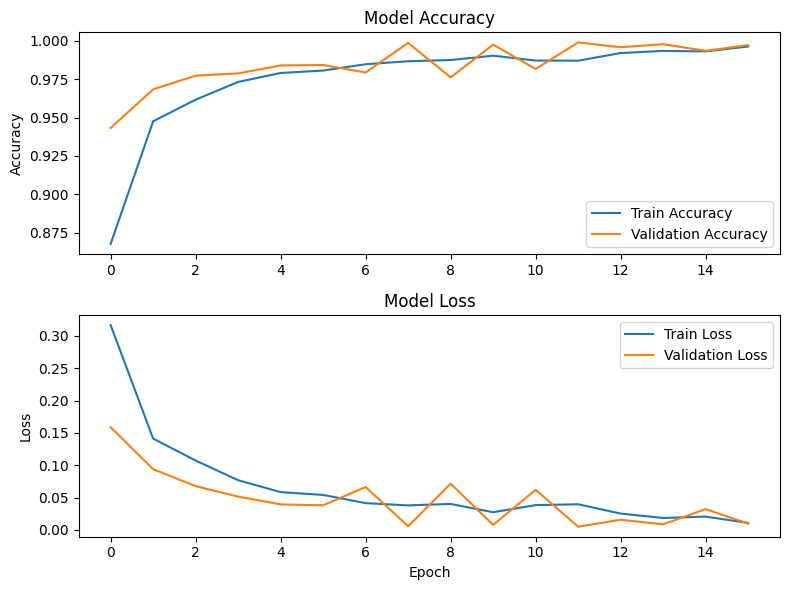

In [ ]:
# Plot the training, validation, and test accuracy for each epoch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
# ax1.plot(test_acc, label='Test Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Compile the model with the confusion matrix metric
def confusion_matrix_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() #Hàm ravel() được sử dụng để làm phẳng ma trận nhầm lẫn thành một mảng 1 chiều, sau đó được giải nén thành bốn biến.
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall) #harmonic mean of precision and recall
    return f1_score

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', confusion_matrix_metric])
# optimizer = adam: optimize algorithm to be used during training, adam optimizer is SGD
# SGD: stochastic gradient descent to show performance

110/110 [==============================] - 2s 4ms/step
[[1941   10]
 [  29 1535]]


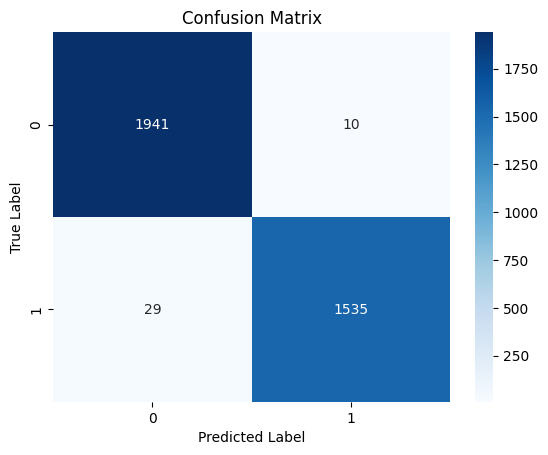

In [ ]:
# Make predictions on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Dựa vào confusion matrix, cho thấy model nhận diện khá là tốt. TP (true positive) hay recall hơn 0.95, tức nhận diện đúng khoảng 95% là ngã chính xác. Nghĩa là sẽ có 38 trường hợp người đó ngã thật nhưng model nhận diện là không ngã (2%). Khi đánh giá trên bộ data train và validation set.